# Create a final gene list from the master rankings

The ge_data_manager software generates a csv value with the ranking of each probe on each optimization run. It then generates a p-value vs each shuffle type, indicating how often the probe performed better in shuffled data than real data. The final gene lists we use should BOTH be highly ranked overall, and perform better in real data than shuffled.

Eventually, each probe has a 'delta' score, indicating how much higher its average ranking in real data is compared to a given set of permutations. Each probe has a p-value, which is the percentage of optimizations in a given permutation that rank higher than its average in real data. And each probe has an average raw ranking, which is how high it climbed in the original optimization in real data. In order for a probe to be considered associated with connectivity, it must rank in the top 1% overall and outperform all shuffles at the p<0.05 level. It is undetermined how much higher its average real rank should be over shuffles.

In [6]:
""" Set up context and load data. """

import os
import pandas as pd

base_dir = "/data/plots"
files = {}
dfs = {}
for split_num in ["4", ]:
    for mask in ["00", "16", "32", "64", ]:
        # Determine variables
        idx = "_".join([split_num, mask, ])
        filename = "hcpww{}ss{}peak_ranked_full.csv".format(mask, split_num)
        filepath = os.path.join(base_dir, filename)
        
        # Store file path
        files[idx] = filepath
        
        # Load data and re-index with 1-based ranking
        dfs[idx] = pd.read_csv(filepath).sort_values('raw_rank')


In [12]:
""" Save out ermineJ-able tsv files with p-values for gene scores, indexed by entrez_id. """

import os
import pandas as pd


go_path = "/home/mike/Dropbox/Projects/GE-Conn/gene_ontology/2020-04_gene_rankings"
for k, df in dfs.items():
    df.set_index('entrez_id').rename(
        columns={'p_by-count_for-agno': 'agno_p', 'p_by-count_for-dist': 'dist_p', 'p_by-count_for-be04': 'be04_p', }
    )[['agno_p', 'dist_p', 'be04_p', ]].to_csv(
        os.path.join(go_path, "p_by-count-lt-mean-rank_mask-{}.tsv".format(k.split("_")[1])),
        sep="\t", 
    )


In [4]:
""" Define a plot to see the relationship between overall ranking and p-value. """

import seaborn as sns
from matplotlib import pyplot as plt


def p_vs_rank(df, shuffle):
    """ Plot the named p_name vs mean ranking in full ranking dataframe, df. """
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    delta_str = "delta_" + shuffle
    p_str = "p_" + shuffle
    
    delta_threshold = int(min(df.sort_values(delta_str, ascending=False)[delta_str][:int(len(df) * 0.05)]))
    lo_p_mask = df[p_str] < 0.05
    hi_delta_mask = df[delta_str] > delta_threshold
    
    sns.scatterplot(
        x=delta_str, y='mean', data=df[~lo_p_mask],
        color='gray', alpha=0.5, size=2, ax=ax
    )
    sns.scatterplot(
        x=delta_str, y='mean', data=df[lo_p_mask], color='red', size=5, ax=ax
    )
    # sns.scatterplot(
    #     x='mean', y=delta_str, data=df[hi_delta_mask], color='blue', size=3, ax=ax
    # )
    # sns.scatterplot(
    #     x='mean', y=delta_str, data=df[lo_p_mask & hi_delta_mask], color='red', size=4, ax=ax
    # )
    sns.regplot(
        x=delta_str, y='mean', data=df, scatter=False, color='black', ax=ax)
    
    ax.set_xlim((-12000, 12000))
    ax.set_ylim((-300, 16000))
    ax.invert_yaxis()
    
    ax.get_legend().remove()
    
    ax.set_title("Average raw ranking - delta vs {}".format(shuffle))
    
    print("{}: {:,} with p<0.05, {:,} with delta>{}, {:,} with both. Leaves {:,} with nothing.".format(
        shuffle, sum(lo_p_mask), sum(hi_delta_mask), delta_threshold,
        sum(lo_p_mask & hi_delta_mask), sum(~lo_p_mask & ~hi_delta_mask)
    ))
    
    return fig, ax


In [7]:
""" Define a plot to see the relationship between overall ranking and p-value. """

import seaborn as sns
from matplotlib import pyplot as plt


def p_vs_delta(df, shuffle):
    """ Plot the named p_name vs mean ranking in full ranking dataframe, df. """
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    delta_str = "delta_" + shuffle
    p_str = "p_" + shuffle
    
    delta_threshold = int(min(df.sort_values(delta_str, ascending=False)[delta_str][:int(len(df) * 0.05)]))
    lo_p_mask = df[p_str] < 0.05
    hi_delta_mask = df[delta_str] > delta_threshold
    rank_threshold = int(max(df.sort_values('rank', ascending=True)['rank'][:100]))
    lo_rank = df['rank'] < rank_threshold
    
    sns.scatterplot(
        x=delta_str, y=p_str, data=df[~lo_rank],
        color='gray', alpha=0.5, size=2, ax=ax
    )
    sns.scatterplot(
        x=delta_str, y=p_str, data=df[lo_rank], color='red', size=5, ax=ax
    )
    # sns.scatterplot(
    #     x='mean', y=delta_str, data=df[hi_delta_mask], color='blue', size=3, ax=ax
    # )
    # sns.scatterplot(
    #     x='mean', y=delta_str, data=df[lo_p_mask & hi_delta_mask], color='red', size=4, ax=ax
    # )
    sns.regplot(
        x=delta_str, y=p_str, data=df, scatter=False, color='black', ax=ax)
    
    ax.set_xlim((-12000, 12000))
    ax.set_ylim((-0.1, 1.1))
    ax.invert_yaxis()
    
    ax.get_legend().remove()
    
    ax.set_title("p-value over delta, vs {}".format(shuffle))
    
    print("{}: {:,} with p<0.05, {:,} with delta>{}, {:,} with both. Leaves {:,} with nothing.".format(
        shuffle, sum(lo_p_mask), sum(hi_delta_mask), delta_threshold,
        sum(lo_p_mask & hi_delta_mask), sum(~lo_p_mask & ~hi_delta_mask)
    ))
    
    return fig, ax


In [94]:
""" Create scatter plots for several contexts. """

for split_num in ["2", "4", ]:
    for mask in ["00", "16", "32", "64", ]:
        for shuffle in ["be04", "dist", "agno", ]:
            f, a = p_vs_rank(dfs["_".join([split_num, mask])], shuffle)
            f.savefig("./p_{}_vs_rank_{}_{}mm.png".format(shuffle, split_num, mask))
            f.clf()


be04: 3,094 with p<0.05, 787 with delta>7082, 763 with both. Leaves 12,627 with nothing.
dist: 197 with p<0.05, 787 with delta>4022, 131 with both. Leaves 14,892 with nothing.
agno: 426 with p<0.05, 787 with delta>6154, 326 with both. Leaves 14,858 with nothing.
be04: 2,650 with p<0.05, 788 with delta>7035, 751 with both. Leaves 13,058 with nothing.
dist: 212 with p<0.05, 788 with delta>4049, 138 with both. Leaves 14,883 with nothing.
agno: 444 with p<0.05, 788 with delta>6146, 339 with both. Leaves 14,852 with nothing.
be04: 1,881 with p<0.05, 787 with delta>6732, 700 with both. Leaves 13,777 with nothing.
dist: 217 with p<0.05, 787 with delta>4137, 143 with both. Leaves 14,884 with nothing.
agno: 410 with p<0.05, 787 with delta>6084, 321 with both. Leaves 14,869 with nothing.
be04: 1,060 with p<0.05, 787 with delta>6563, 564 with both. Leaves 14,462 with nothing.
dist: 191 with p<0.05, 787 with delta>4213, 131 with both. Leaves 14,898 with nothing.
agno: 428 with p<0.05, 787 with del

/home/mike/.local/share/virtualenvs/schmidt_geconn-js2EyY9C/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


agno: 135 with p<0.05, 788 with delta>5087, 134 with both. Leaves 14,956 with nothing.


/home/mike/.local/share/virtualenvs/schmidt_geconn-js2EyY9C/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


be04: 208 with p<0.05, 787 with delta>4997, 187 with both. Leaves 14,937 with nothing.


/home/mike/.local/share/virtualenvs/schmidt_geconn-js2EyY9C/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


dist: 12 with p<0.05, 787 with delta>3348, 11 with both. Leaves 14,957 with nothing.


/home/mike/.local/share/virtualenvs/schmidt_geconn-js2EyY9C/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


agno: 128 with p<0.05, 787 with delta>4848, 128 with both. Leaves 14,958 with nothing.


<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

be04: 607 with p<0.05, 788 with delta>5346, 374 with both. Leaves 14,724 with nothing.


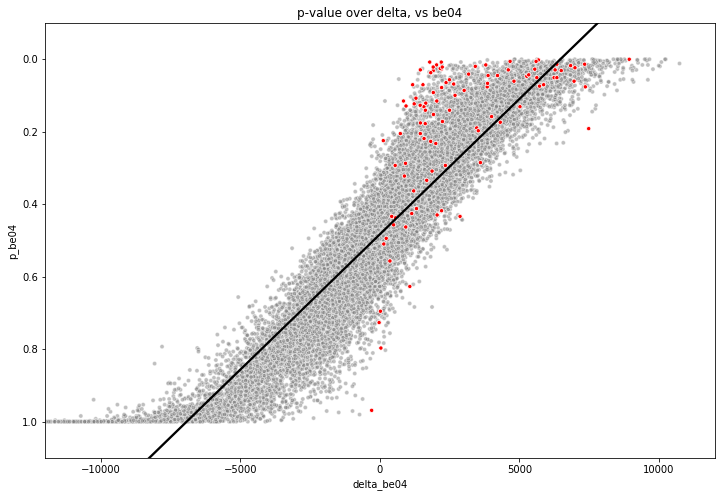

In [8]:
f, a = p_vs_delta(dfs["_".join(["4", "16"])], "be04")
f.savefig("./p_{}_vs_delta_{}_16mm.png".format("be04", "4"))


In [58]:
""" Define a plot to see the distribution of deltas. """

import seaborn as sns
from matplotlib import pyplot as plt


def delta_distribution(df, shuffle):
    """ Plot the distribution of deltas for a given shuffle. """
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    sns.distplot(df["delta_" + shuffle])
    
    return fig, ax


In [ ]:
f, a = delta_distribution(ranking_halves_16mm, 'be04')
